In [12]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

In [13]:
def rotate_image_cv2(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Image has to be uint8
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),	flags = cv2.INTER_NEAREST)
    return rotated_mat

In [14]:
dlsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined'
roisrc = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_v2_021723'
dst = os.path.join(dlsrc, 'DLcrop')
if not os.path.exists(dst): os.mkdir(dst)

In [15]:
imlist = glob.glob(os.path.join(dlsrc,'*.tif'))
imlist = natsorted(imlist)

In [16]:
whitespace=12
minDermhole = 5000
minepisize=1000
df=[]

In [17]:
#output d0 as csv with filename, sectionid, d0, edited as columns
#edit d0 in the csv, and label edited column as '1'
#write a code block that reads edited d0 that are labeled as '1'
    #details: keep track of new angle and old angle
#rotate these images and overwrite existing image

In [29]:
for imname in imlist[0:10]:
    # open DL
    dl = Image.open(imname)
    dlarr = np.array(dl)
    # open ROI
    roi_nm = os.path.basename(imname)
    roi_nm = roi_nm.replace(".tif", ".png" )
    roi_pth = os.path.join(roisrc,roi_nm)
    if not os.path.exists(roi_pth):
        print("no roi found")
        continue
    roi = Image.open(roi_pth)

    roiarr = np.array(roi)
    Nroi = np.max(roiarr)
    # define epidermis and dermis to calculate rotation angle later
    epi = (dlarr == 1) | (dlarr == 2)
    derm = (2 < dlarr) & (dlarr < whitespace)
    derm = remove_small_holes(derm, area_threshold=minDermhole)
    epi2 = epi & ~derm
    epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)
    # iterate ROI
    for secid in range(1,Nroi):
        print('section N: ', secid+1, '/', Nroi+1)
        dlroi = deepcopy(dlarr) #copy dlmask

        #reshape roi if it's not the same shape as dlroi

        if ((roiarr.shape[0] != dlroi.shape[0]) | (roiarr.shape[1] != dlroi.shape[1])):
            roiarr = cv2.resize(roiarr, dsize=(dlroi.shape[1],dlroi.shape[0]),interpolation=cv2.INTER_NEAREST)
            print(roiarr.shape)
            print(dlroi.shape)
            print(imname)

        dlroi[roiarr != secid+1] = 0 #remove dlmask outside of roi
        dlepi = dlroi & epi2 # select epidermis within roi
        # align horizontal
        [xt2, yt2] = np.where(dlepi) # convert epidermis mask to coordinates within the mask
        vertices = np.array([xt2[::10], yt2[::10]]).T # subsample by 10 to expedite
        vc = vertices - vertices.mean(axis=0) # normalize epidermis coordinates to center at zero
        U, S, Vt = np.linalg.svd(vc) # apply singular value decomposition to calculate rotational angle
        k = Vt.T
        d0 = degrees(atan2(k[1, 1], k[1, 0]))  # arctan of sin/cos in degrees
        d0special = False
        if np.linalg.det(k) < 0: # check special-case in converting svd vector to rotational angle
            d0special = True
            d0 = -d0
        if d0 < 0: d0 = d0 + 360 # check whether rotational angle is negative, then add 360 to make it positive
        d0 = round(d0)
        # crop dlroi to expedite rotation
        [xt, yt] = np.where(dlroi)  # mskrot is sometimes not detected
        dlroic = dlroi[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
        # rotate dlroi
        dlrot = rotate_image_cv2(dlroic,d0)
        # Flips the binary mask if the dermis part is above the epidermis part.
        [xt2, yt2] = np.where((dlrot == 1) | (dlrot == 2)) #xt2 calculated to see if dermis is above epidermis
        d0Flip = False
        if np.mean(xt) - np.mean(xt2) < 0:  # if dermis is above epidermis, flip it
            d0Flip = True
            dlrot = np.rot90(np.rot90(dlrot))
            d0 += 180
        # crop rotated dlroi
        [xt, yt] = np.where(dlrot)  # mskrot is sometimes not detected
        dlrotc = dlrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
        # write rotate deeplab mask
        pth_name = os.path.join(dst, '{}_sec{:02d}.png'.format(roi_nm[:-4], secid))
        Image.fromarray(dlrotc.astype('int8')).save(
           pth_name)

         #add to dataframe
        df.append({'imname':pth_name, 'secN': secid, 'degrot': d0,  'edited':0})
        df2 = pd.DataFrame(df)


section N:  2 / 5
section N:  3 / 5
section N:  4 / 5
section N:  2 / 5
(19275, 40696)
(19275, 40696)
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\2022-06-07 13.51.05.tif
section N:  3 / 5
section N:  4 / 5
section N:  2 / 4
section N:  3 / 4
section N:  2 / 3


In [30]:
#save csv
df2.to_csv( os.path.join(dst,'CLUEdegrot.csv'))

In [48]:
#read csv {'imname': roi_nm, 'secN': secid, 'degrot': d0,  'edited':0, 'new_degrot': ...}
csv = pd.read_csv(os.path.join(dst,'CLUEdegrot.csv'))
csv

,Unnamed: 0,imname,secN,degrot,edited,new_degrot
0,0,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,1,107,1,80.0
1,1,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,2,125,1,90.0
2,2,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,3,128,0,NaN
3,3,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,1,52,0,NaN
4,4,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,2,57,0,NaN
5,5,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,3,58,0,NaN
6,6,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,1,58,0,NaN
7,7,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,2,58,1,180.0
8,8,\\shelter\Kyu\skin_aging\clue_cohort\HE1um\cla...,1,208,0,NaN


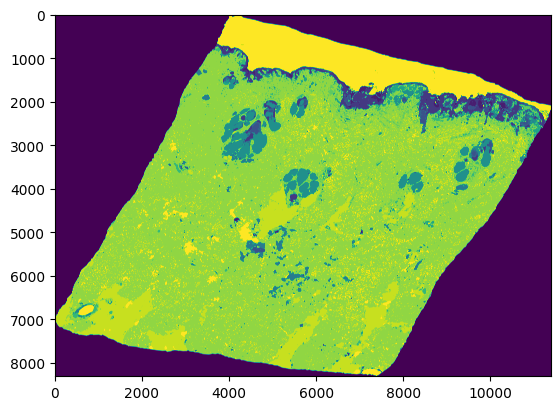

In [52]:
#test
row = csv.iloc[7]
im = Image.open(pth_name)
im_arr = np.array(im)

new_degrot = row['new_degrot']
old_degrot = row['degrot']
finald0 = 0
im_rot = rotate_image_cv2(im_arr,0)
plt.imshow(im_rot)




In [ ]:
for row in csv.iterrows[0:1]:
    if(row['edited'] != 1): continue

    im = Image.open( os.path.join(dst,row['imname']))
    im_arr = np.toarray(im)

    new_degrot = row['new_degrot']
    old_degrot = row['degrot']
    #finald0 = old_degrot + new_degrot





